# Machine Learning Engineer Nanodegree
## Capstone
## Project: Air pressure system failures in Scania trucks

## Libraries Used (Imports)

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display # Allows the use of display() for DataFrames

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

import xgboost as xgb

# Pretty display for notebooks
%matplotlib inline

random_seed = 42

## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

In [2]:
# Load the trianing/Test dataset
try:
    train = pd.read_csv('data/aps_failure_training_set_processed_8bit.csv')
    test = pd.read_csv('data/aps_failure_test_set_processed_8bit.csv')
except:
    print("Dataset could not be loaded. Is the dataset missing?")

In [10]:
# Display a description of the dataset
display(train.shape)
display(test.shape)

(60000, 171)

(16000, 171)

In [11]:
train.tail(3)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
59997,0,-0.406250,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
59998,0,0.140625,0.304688,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.218750,0.023438,-0.085938,-0.148438,-0.132812,-0.101562,0.992188,0.992188,-0.023438,-0.023438
59999,0,-0.132812,0.281250,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.007812,-0.046875,-0.085938,-0.125000,-0.101562,-0.109375,0.070312,-0.171875,-0.023438,-0.023438


In [3]:
train['class'] = train['class'].apply(lambda x: 0 if x<=0 else 1)
test['class'] = test['class'].apply(lambda x: 0 if x<=0 else 1)

X = train.drop('class', axis=1)
y = train['class']

X_test_given = test.drop('class', axis=1)
y_test_given = test['class']

In [4]:
pca = PCA(n_components=86) # Above 99%
pca.fit(X)
reduced_data = pca.transform(X)

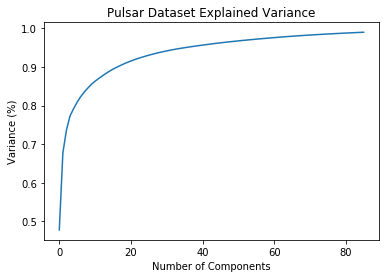

In [5]:
reduced_data.shape
#print(np.cumsum(pca.explained_variance_ratio_))
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data, y, test_size=0.2, stratify=y, random_state=random_seed)

In [7]:
%%time


params = {
'max_depth':[3,5],
'learning_rate':[0.1],
'gamma':[0,3,10],
'min_child_weight':[1,2,3],
'max_delta_step':[5],
'colsample_bytree':[0.8],
'n_estimators':[1000],
'subsample':[0.8],
'objective':['binary:logistic'],
'nthread':[4],
'scale_pos_weight':[1],
'seed':[42],
'verbose': [10]}

model = xgb.XGBClassifier(tree_method='hist')
cv = GridSearchCV(model, params, cv=5, n_jobs=4, scoring='roc_auc')

cv.fit(X_train, y_train)

[22:45:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


NameError: name 'Y_test' is not defined

Took 24 hours! To avoid re-search best hyper params moved the logic to lower cells.

In [37]:
predictor = cv.best_estimator_

print(predictor)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_delta_step=5,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8, tree_method='hist', verbose=10)


In [35]:
from sklearn.metrics import roc_auc_score

score = predictor.predict_proba(X_train)
print('Best ROC-AUC: {:.4f}'.format(roc_auc_score(y_train, score[:, 1], average='macro')))

Best ROC-AUC: 0.9999


In [10]:
cv.score(X_test, y_test)

print("Best parameters: %s" % cv.best_params_)
print("Best auroc score: %s" % cv.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 3, 'learning_rate': 0.1, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 42, 'subsample': 0.8, 'verbose': 10}
Best auroc score: 0.9885541578389831


In [15]:
cv.score(pca.transform(X_test_given), y_test_given)
print("Best parameters: %s" % cv.best_params_)
print("Best auroc score: %s" % cv.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 3, 'learning_rate': 0.1, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 42, 'subsample': 0.8, 'verbose': 10}
Best auroc score: 0.9885541578389831


In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predict = predictor.predict(pca.transform(X_test_given))

In [39]:
accuracy_score( y_test_given, predict)

0.9886875

In [40]:
confusion_matrix(y_true = y_test_given, y_pred = predict )

array([[15595,    30],
       [  151,   224]])

In [41]:
print(classification_report( y_true = y_test_given, y_pred = predict ))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.88      0.60      0.71       375

   micro avg       0.99      0.99      0.99     16000
   macro avg       0.94      0.80      0.85     16000
weighted avg       0.99      0.99      0.99     16000



In [42]:
predictor.feature_importances_

array([0.01881284, 0.02984106, 0.01167694, 0.01654233, 0.00908206,
       0.00746027, 0.00713591, 0.01265002, 0.01946156, 0.02432695,
       0.01070386, 0.00908206, 0.01135258, 0.00940642, 0.00810898,
       0.01524489, 0.03178722, 0.01135258, 0.01686669, 0.0103795 ,
       0.01589361, 0.01362309, 0.0103795 , 0.00973078, 0.02270516,
       0.04022057, 0.01102822, 0.01329874, 0.01459617, 0.00810898,
       0.01070386, 0.01654233, 0.00551411, 0.0087577 , 0.00908206,
       0.01589361, 0.00518975, 0.01362309, 0.00713591, 0.00843334,
       0.00746027, 0.01167694, 0.01232566, 0.01265002, 0.00973078,
       0.00551411, 0.00551411, 0.00973078, 0.00778463, 0.00940642,
       0.00616283, 0.0087577 , 0.00681155, 0.0103795 , 0.00583847,
       0.01654233, 0.00648719, 0.00713591, 0.00713591, 0.00551411,
       0.00518975, 0.0120013 , 0.01362309, 0.00940642, 0.01135258,
       0.02302952, 0.00810898, 0.01135258, 0.00940642, 0.00681155,
       0.00746027, 0.01751541, 0.00843334, 0.00843334, 0.00940

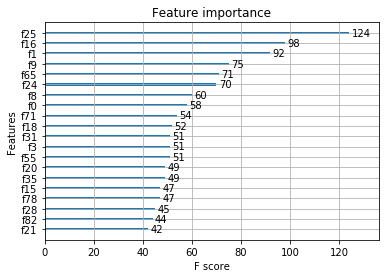

In [58]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(predictor, max_num_features = 20)
pyplot.show()